## Comparison of CMIP6 and CMIP6plus GHG concentrations

Author: Vaishali Naik

Date: June 13, 2024

Read and plot global/NH/SH mean GHG concentrations 

In [2]:
#Load required python tools
from glob import glob
import xarray as xr
import pandas as pd
import copy 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import re

In [3]:
#Set directories
cmip6dir = "/archive/uda/input4MIPs/CMIP6/CMIP/UoM/UoM-CMIP-1-2-0/atmos/yr/"
cmip6pdir = "/net2/van/cmip6plus/ghg/input4MIPs/CMIP6Plus/CMIP/CR/CR-hist-ghg-concs-0.1.0/atmos/yr/"
plotdir = "/home/van/projs/cmip7/ghg/pngs/"

In [51]:
#Define list of variables for plotting
plist = ['carbon-dioxide','methane','nitrous-oxide','cfc11','cfc12','cfc113','cfc114','ch3ccl3','hcfc22','hcfc141b',
         'halon1301','methyl-bromide','methyl-chloride','carbon-tetrachloride','sf6']
years = np.arange(0.5, 2023.5,1)

In [76]:
#Define region and figure file
preg = 1 #global=0, NH=1, SH=2
region = 'NH'
figfile = plotdir+"nh.ghg_comparison.png"

In [77]:
def create_ghg_frames(cmipera,direc):
    flist = [os.path.join(r,file) for r,d,f in os.walk(direc) for file in f]
    splist = []
    for nm in flist:
        if cmipera == "CMIP6": 
            fnames = nm.split('/')[10]
        elif cmipera == "CMIP6Plus":
            fnames = nm.split('/')[12]
        else: 
            print("error, define cmipera to proceed further")
        # Using regular expression to extract the string between 'of-' and '-in-air'
        match = re.search(r'of-(.*?)-in-air', fnames)
        # Extracting the matched string
        if match:
            extracted_string = match.group(1)
            splist.append(extracted_string)
        else:
            print("No match found")
    # print("species in "+cmipera)
    # display(splist)
    P = pd.DataFrame()
    units = []
    for item in plist:
        if cmipera == "CMIP6Plus":
            if item == "sf6":
                item ="sulfur-hexafluoride"
            elif item == "ch3ccl3":
                item = "hcc140a"  
        for i,sp in enumerate(splist):
            if item == sp:
                infile = flist[i]
                if cmipera == "CMIP6": 
                    fx = infile.split('/')[10]
                elif cmipera == "CMIP6Plus":
                    fx = infile.split('/')[12]
                else: 
                    print("error, don't know how to get the variable name") 
                fx=fx.replace('-', '_')
                d = xr.open_mfdataset(infile,decode_times=False)            
                x = d[fx].sel(sector=preg).drop('time')
                unit = d[fx].attrs['units']  #ds.attrs.keys()
                units.append(unit) 
                if item=='sulfur-hexafluoride':
                    df=x.to_dataframe(name='sf6')
                elif item=='hcc140a':
                    df=x.to_dataframe(name='ch3ccl3')
                else:
                    df=x.to_dataframe(name=item)
                dff=df.drop(['sector'],axis=1)            
                P = pd.concat([P,dff],axis=1)            
    P.index.names = [None]
    P['mipera']=cmipera
    if cmipera == "CMIP6": 
        P=P.reset_index().set_index(years[0:2015])
    elif cmipera == "CMIP6Plus": 
        P=P.reset_index().set_index(years[1:2023])    
    P.index.name = 'Years'
    P = P.drop(columns=['index'],errors='ignore')
    return P, units    

In [83]:
def plot_ghg (combined_df, units):
    stitle='Comparison of '+region+' Mean GHG concentrations between CMIP6 and CMIP6Plus'
    sns.set_style("ticks")
    sns.set_context("paper", font_scale = 1.9, rc={"grid.linewidth": 2})
    custom_params = {"axes.grid": True,'axes.edgecolor': 'black',"grid.color": ".6", "grid.linestyle": ":"}
    sns.set_theme(font_scale= 1.4, rc=custom_params)

    g = sns.relplot(data=combined_df, x='Years', y='concentration', col='ghg', hue="mipera", 
                kind="line",linewidth=2,col_wrap=3,height=4.5, aspect=1.6, facet_kws={'sharey': False,'sharex':False,'despine':False})
# g.set_titles('')
    g.set_axis_labels("Year","")

    for i, ax in enumerate(g.axes.flatten()):
        ax.set_ylabel(units[i])
        ax.set_facecolor('white')
        ax.tick_params(bottom=True, left=True)
        # ax.text(0.0, 1.02,splist_cmip6[i], fontsize=16, transform=ax.transAxes) #add text

        sns.move_legend(g, "lower right",
        bbox_to_anchor=(.22, 0.95), ncol=2, title=None, frameon=False)
    g.fig.subplots_adjust(wspace=0.25,hspace=0.2)
    plt.suptitle(stitle, y=1.02)
    plt.savefig(figfile)

In [80]:
df_cmip6, units = create_ghg_frames('CMIP6',cmip6dir)
df_cmip6p, units = create_ghg_frames('CMIP6Plus',cmip6pdir)

In [81]:
xplot = pd.concat([df_cmip6,df_cmip6p],axis=0) 
xplot_melted = xplot.reset_index().melt(id_vars=['Years','mipera'], value_vars=plotlist, var_name='ghg', value_name='concentration')
# xplot

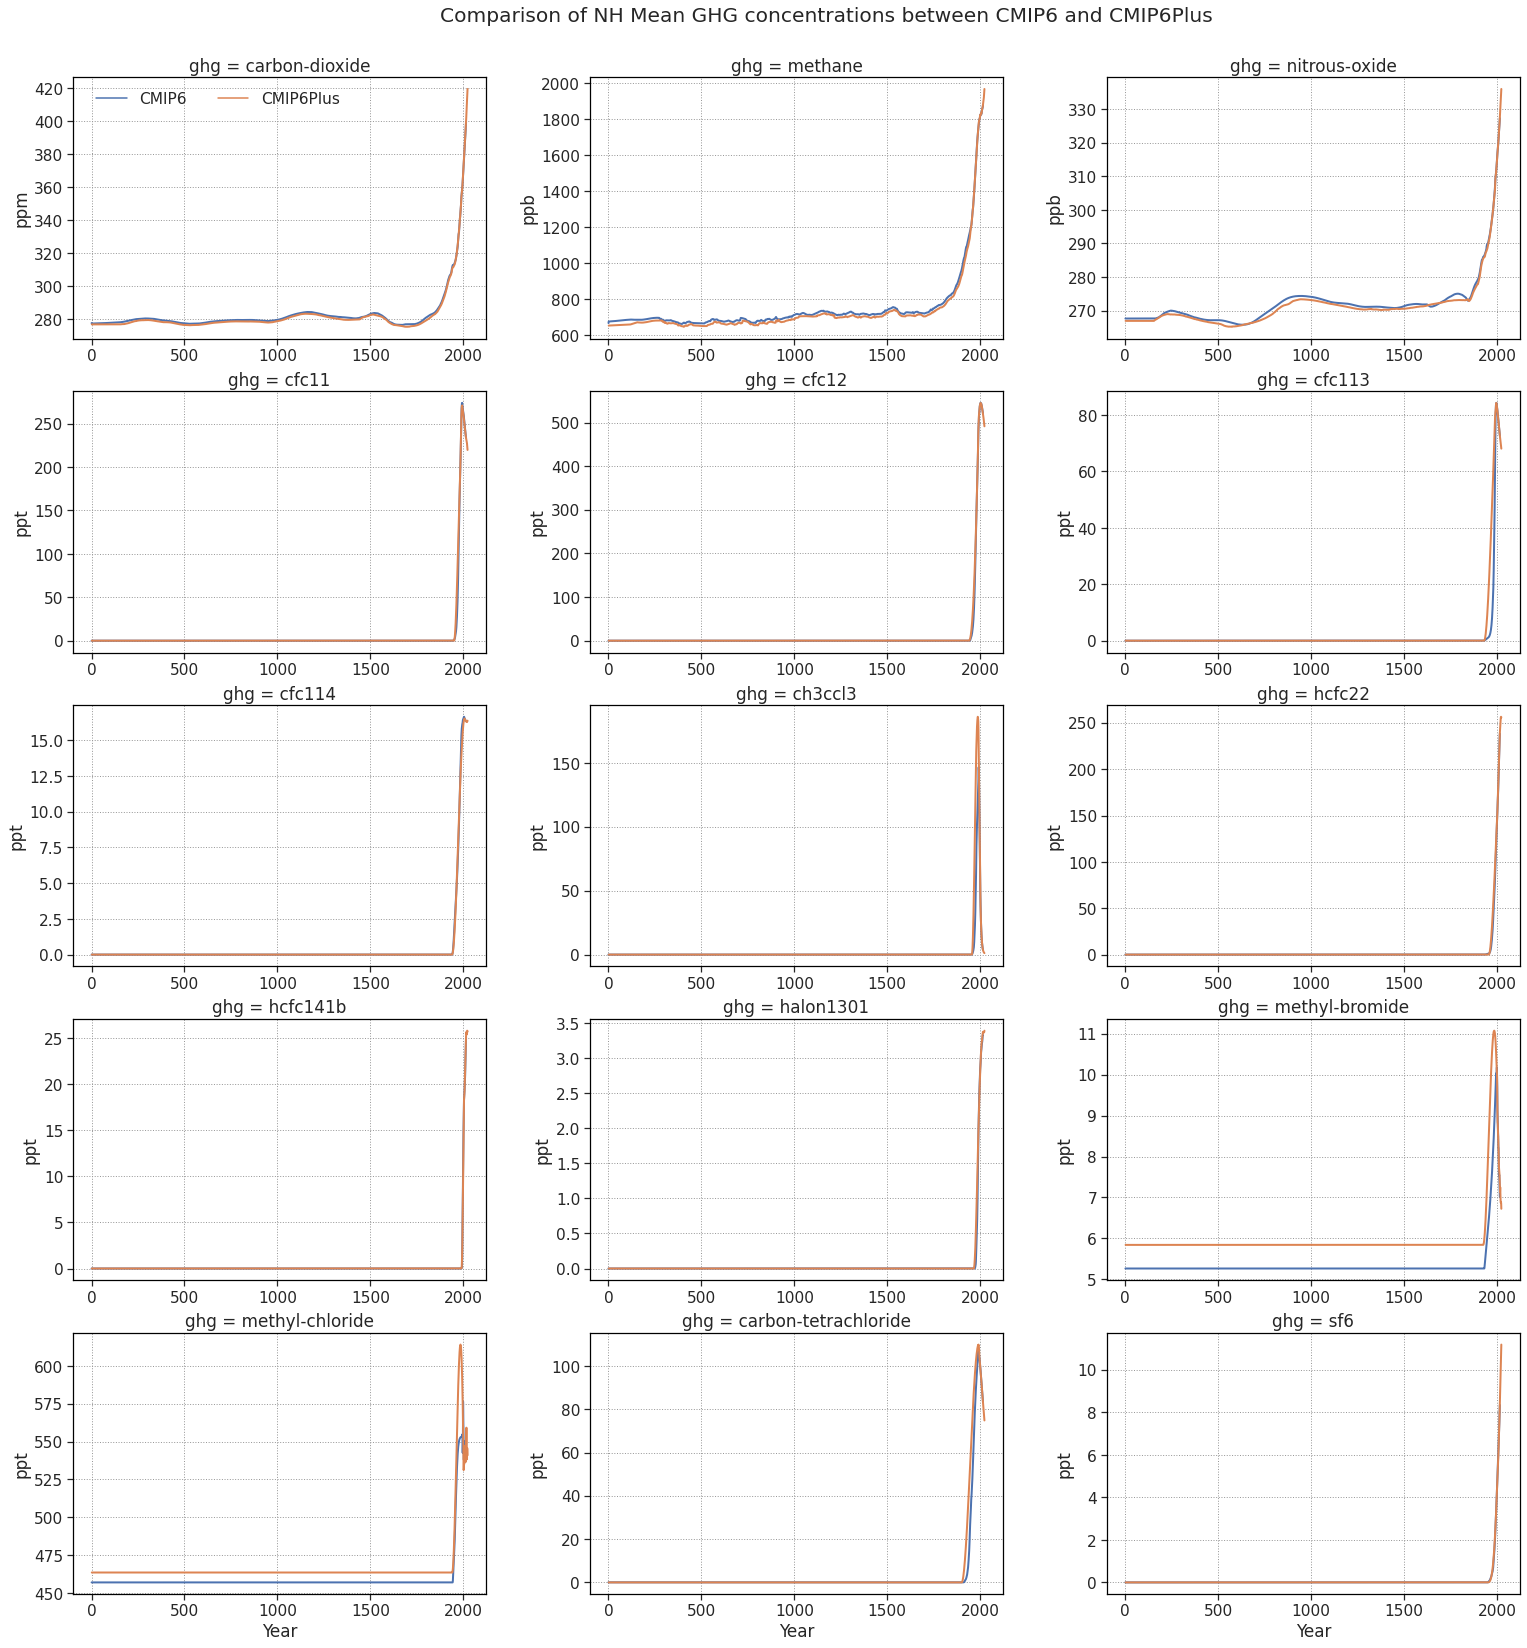

In [85]:
plot_ghg(xplot_melted,units)

In [12]:
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory